In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
from func_get import *
from func_signal import *
from func_backtest import *

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'cross'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '15m',
    'target_side': ['buy'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '15m': {
                'cross_sma': {
                    'check': [check_signal_side_change],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        },
        'close': {
            '15m': {
                'cross_sma': {
                    'check': [check_signal_side],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/107
base: timeframe 1/1 symbol 1/1 date 2/107
base: timeframe 1/1 symbol 1/1 date 3/107
base: timeframe 1/1 symbol 1/1 date 4/107
base: timeframe 1/1 symbol 1/1 date 5/107
base: timeframe 1/1 symbol 1/1 date 6/107
base: timeframe 1/1 symbol 1/1 date 7/107
base: timeframe 1/1 symbol 1/1 date 8/107
base: timeframe 1/1 symbol 1/1 date 9/107
base: timeframe 1/1 symbol 1/1 date 10/107
base: timeframe 1/1 symbol 1/1 date 11/107
base: timeframe 1/1 symbol 1/1 date 12/107
base: timeframe 1/1 symbol 1/1 date 13/107
base: timeframe 1/1 symbol 1/1 date 14/107
base: timeframe 1/1 symbol 1/1 date 15/107
base: timeframe 1/1 symbol 1/1 date 16/107
base: timeframe 1/1 symbol 1/1 date 17/107
base: timeframe 1/1 symbol 1/1 date 18/107
base: timeframe 1/1 symbol 1/1 date 19/107
base: timeframe 1/1 symbol 1/1 date 20/107
base: timeframe 1/1 symbol 1/1 date 21/107
base: timeframe 1/1 symbol 1/1 date 22/107
base: timeframe 1/1 symbol 1/1 date 23/107
base: timeframe 1/1 

### Add signal

In [10]:
ohlcv_df_dict = add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add cross_sma to ETH-PERP 15m
base add cross_sma to ETH-PERP 15m


### Back test

In [11]:
action_time_list = gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 00:15:00: progress 1/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:30:00: progress 2/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:45:00: progress 3/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:00:00: progress 4/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:15:00: progress 5/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:30:00: progress 6/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:45:00: progress 7/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 02:00:00: progress 8/9220

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:15:00: progress 277/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:30:00: progress 278/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:45:00: progress 279/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 22:00:00: progress 280/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 22:15:00: progress 281/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 22:30:00: progress 282/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 22:45:00: progress 283/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 23:00:00: progress 284/9220
  E

     Not close
Time 2022-01-05 14:15:00: progress 441/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 14:30:00: progress 442/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 14:45:00: progress 443/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 15:00:00: progress 444/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 15:15:00: progress 445/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 15:30:00: progress 446/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 15:45:00: progress 447/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 16:00:00: progress 448/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 1

Time 2022-01-08 04:30:00: progress 690/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 04:45:00: progress 691/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:00:00: progress 692/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:15:00: progress 693/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:30:00: progress 694/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:45:00: progress 695/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 06:00:00: progress 696/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 06:15:00: p

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 16:30:00: progress 930/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 16:45:00: progress 931/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 17:00:00: progress 932/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 17:15:00: progress 933/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 17:30:00: progress 934/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 17:45:00: progress 935/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 18:00:00: progress 936/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 18:15:00: progress 937/9220
  E

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 14:45:00: progress 1115/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 15:00:00: progress 1116/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 15:15:00: progress 1117/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 15:30:00: progress 1118/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 15:45:00: progress 1119/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 16:00:00: progress 1120/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 16:15:00: progress 1121/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 16:30:00: progress 1122/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 06:15:00: progress 1273/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 06:30:00: progress 1274/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 06:45:00: progress 1275/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 07:00:00: progress 1276/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 07:15:00: progress 1277/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 07:30:00: progress 1278/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-14 07:45:00: progress 1279/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 08:15:00: progress 1473/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 08:30:00: progress 1474/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 08:45:00: progress 1475/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 09:00:00: progress 1476/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 09:15:00: progress 1477/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 09:30:00: progress 1478/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 09:45:00: progress 1479/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 10:00:00: progress 1480/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 22:30:00: progress 1722/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 22:45:00: progress 1723/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 23:00:00: progress 1724/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 23:15:00: progress 1725/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 23:30:00: progress 1726/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 23:45:00: progress 1727/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-19 00:00:00: progress 1728/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 08:30:00: progress 1954/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 08:45:00: progress 1955/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 09:00:00: progress 1956/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 09:15:00: progress 1957/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 09:30:00: progress 1958/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 09:45:00: progress 1959/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 10:00:00: progress 1960/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 23:00:00: progress 2204/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 23:15:00: progress 2205/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 23:30:00: progress 2206/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 23:45:00: progress 2207/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 00:00:00: progress 2208/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 00:15:00: progress 2209/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 00:30:00: progress 2210/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 22:30:00: progress 2394/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 22:45:00: progress 2395/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 23:00:00: progress 2396/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 23:15:00: progress 2397/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 23:30:00: progress 2398/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 23:45:00: progress 2399/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 00:00:00: progress 2400/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 00:15:00: progress 2401/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 18:00:00: progress 2568/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 18:15:00: progress 2569/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 18:30:00: progress 2570/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 18:45:00: progress 2571/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 19:00:00: progress 2572/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 19:15:00: progress 2573/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 19:30:00: progress 2574/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 20:30:00: progress 2770/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 20:45:00: progress 2771/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 21:00:00: progress 2772/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 21:15:00: progress 2773/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 21:30:00: progress 2774/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 21:45:00: progress 2775/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 22:00:00: progress 2776/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 22:15:00: progress 2777/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:30:00: progress 2946/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:45:00: progress 2947/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:00:00: progress 2948/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:15:00: progress 2949/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:30:00: progress 2950/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:45:00: progress 2951/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 18:00:00: progress 2952/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 22:30:00: progress 3162/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 22:45:00: progress 3163/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 23:00:00: progress 3164/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 23:15:00: progress 3165/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 2647.7
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-02-02 23:30:00: progress 3166/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-02 23:45:00: progress 3167/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 00:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:15:00: progress 3361/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:30:00: progress 3362/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:45:00: progress 3363/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:00:00: progress 3364/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:15:00: progress 3365/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:30:00: progress 3366/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:45:00: progress 3367/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 02:00:00: progress 3368/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 15:00:00: progress 3516/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 15:15:00: progress 3517/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 15:30:00: progress 3518/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 15:45:00: progress 3519/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:00:00: progress 3520/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:15:00: progress 3521/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:30:00: progress 3522/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:45:00: progress 3523/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 13:15:00: progress 3701/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 13:30:00: progress 3702/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 13:45:00: progress 3703/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 14:00:00: progress 3704/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 14:15:00: progress 3705/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 14:30:00: progress 3706/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 14:45:00: progress 3707/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 15:00:00: progress 3708/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 16:15:00: progress 3905/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 16:30:00: progress 3906/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 16:45:00: progress 3907/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 17:00:00: progress 3908/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 17:15:00: progress 3909/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 17:30:00: progress 3910/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 17:45:00: progress 3911/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 18:00:00: progress 3912/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:00:00: progress 4124/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:15:00: progress 4125/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:30:00: progress 4126/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:45:00: progress 4127/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 00:00:00: progress 4128/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 00:15:00: progress 4129/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 00:30:00: progress 4130/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 09:45:00: progress 4359/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 10:00:00: progress 4360/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 10:15:00: progress 4361/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 10:30:00: progress 4362/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 10:45:00: progress 4363/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 11:00:00: progress 4364/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 11:15:00: progress 4365/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 11:30:00: progress 4366/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 02:30:00: progress 4522/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 02:45:00: progress 4523/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 03:00:00: progress 4524/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 03:15:00: progress 4525/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 03:30:00: progress 4526/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 03:45:00: progress 4527/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 04:00:00: progress 4528/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-17 04:15:00: progress 4529/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 07:45:00: progress 4735/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 08:00:00: progress 4736/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 08:15:00: progress 4737/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 08:30:00: progress 4738/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 08:45:00: progress 4739/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 09:00:00: progress 4740/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 09:15:00: progress 4741/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 16:15:00: progress 4961/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 16:30:00: progress 4962/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 16:45:00: progress 4963/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 17:00:00: progress 4964/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 17:15:00: progress 4965/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 17:30:00: progress 4966/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 17:45:00: progress 4967/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-21 18:00:00: progress 4968/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 19:15:00: progress 5165/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 19:30:00: progress 5166/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 19:45:00: progress 5167/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 20:00:00: progress 5168/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 20:15:00: progress 5169/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 20:30:00: progress 5170/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 20:45:00: progress 5171/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 21:00:00: progress 5172/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 00:30:00: progress 5378/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 00:45:00: progress 5379/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 01:00:00: progress 5380/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 01:15:00: progress 5381/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 01:30:00: progress 5382/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 01:45:00: progress 5383/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 02:00:00: progress 5384/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 02:15:00: progress 5385/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 17:00:00: progress 5540/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 17:15:00: progress 5541/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 17:30:00: progress 5542/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.03327593674898249
     price: 2776.6
     tp: inf
     sl: 0
Time 2022-02-27 17:45:00: progress 5543/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 18:00:00: progress 5544/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 18:15:00: progress 5545/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 18:30:00: progress 5546/9220
  ETH-PERP
     ba

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:15:00: progress 5733/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:30:00: progress 5734/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:45:00: progress 5735/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 18:00:00: progress 5736/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 18:15:00: progress 5737/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 18:30:00: progress 5738/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 18:45:00: progress 5739/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 19:00:00: progress 5740/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 06:15:00: progress 5881/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 06:30:00: progress 5882/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 06:45:00: progress 5883/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 07:00:00: progress 5884/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 07:15:00: progress 5885/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 07:30:00: progress 5886/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 07:45:00: progress 5887/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-03 08:00:00: progress 5888/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 22:00:00: progress 6040/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 22:15:00: progress 6041/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 22:30:00: progress 6042/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 22:45:00: progress 6043/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 23:00:00: progress 6044/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 23:15:00: progress 6045/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 23:30:00: progress 6046/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 02:15:00: progress 6249/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 02:30:00: progress 6250/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 02:45:00: progress 6251/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 03:00:00: progress 6252/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 03:15:00: progress 6253/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 03:30:00: progress 6254/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-07 03:45:00: progress 6255/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 03:30:00: progress 6446/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 03:45:00: progress 6447/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 04:00:00: progress 6448/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 04:15:00: progress 6449/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 04:30:00: progress 6450/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 04:45:00: progress 6451/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 05:00:00: progress 6452/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-09 05:15:00: progress 6453/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 15:30:00: progress 6590/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 15:45:00: progress 6591/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 16:00:00: progress 6592/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 16:15:00: progress 6593/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 16:30:00: progress 6594/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 16:45:00: progress 6595/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 17:00:00: progress 6596/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-03-13 04:15:00: progress 6833/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 04:30:00: progress 6834/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 04:45:00: progress 6835/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 05:00:00: progress 6836/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 05:15:00: progress 6837/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 05:30:00: progress 6838/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.03398170186476195
     price: 2588.5
     tp: inf
     sl: 0
Time 2022-03-13 05:45:00: pro

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 03:15:00: progress 7021/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 03:30:00: progress 7022/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 03:45:00: progress 7023/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:00:00: progress 7024/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:15:00: progress 7025/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:30:00: progress 7026/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:45:00: progress 7027/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 21:00:00: progress 7188/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 21:15:00: progress 7189/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 21:30:00: progress 7190/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 21:45:00: progress 7191/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 22:00:00: progress 7192/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 22:15:00: progress 7193/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 22:30:00: progress 7194/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 22:45:00: progress 7195/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 06:00:00: progress 7320/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 06:15:00: progress 7321/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 06:30:00: progress 7322/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 06:45:00: progress 7323/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 07:00:00: progress 7324/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 07:15:00: progress 7325/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 07:30:00: progress 7326/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-18 07:45:00: progress 7327/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 21:30:00: progress 7478/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 21:45:00: progress 7479/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:00:00: progress 7480/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:15:00: progress 7481/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:30:00: progress 7482/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:45:00: progress 7483/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 23:00:00: progress 7484/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 23:15:00: progress 7485/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 16:15:00: progress 7649/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 16:30:00: progress 7650/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 16:45:00: progress 7651/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 17:00:00: progress 7652/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 17:15:00: progress 7653/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 17:30:00: progress 7654/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 17:45:00: progress 7655/9220
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 08:15:00: progress 7809/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 08:30:00: progress 7810/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 08:45:00: progress 7811/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 09:00:00: progress 7812/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 09:15:00: progress 7813/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 09:30:00: progress 7814/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 09:45:00: progress 7815/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 10:00:00: progress 7816/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 00:45:00: progress 7971/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 01:00:00: progress 7972/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 01:15:00: progress 7973/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 01:30:00: progress 7974/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 01:45:00: progress 7975/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 02:00:00: progress 7976/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 02:15:00: progress 7977/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 02:30:00: progress 7978/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-26 22:15:00: progress 8153/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3120.4
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-03-26 22:30:00: progress 8154/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-26 22:45:00: progress 8155/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-26 23:00:00: progress 8156/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-26 23:15:00: progress 8157/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-26 23:30:00: progress 8158/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No a

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 15:45:00: progress 8319/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 16:00:00: progress 8320/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 16:15:00: progress 8321/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 16:30:00: progress 8322/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 16:45:00: progress 8323/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:00:00: progress 8324/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:15:00: progress 8325/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:30:00: progress 8326/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 05:30:00: progress 8470/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 05:45:00: progress 8471/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 06:00:00: progress 8472/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 06:15:00: progress 8473/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 06:30:00: progress 8474/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 06:45:00: progress 8475/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 07:00:00: progress 8476/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 07:15:00: progress 8477/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 21:15:00: progress 8629/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 21:30:00: progress 8630/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 21:45:00: progress 8631/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3357.0
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-03-31 22:00:00: progress 8632/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 22:15:00: progress 8633/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 22:30:00: progress 8634/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 22:4

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 20:00:00: progress 8816/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 20:15:00: progress 8817/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 20:30:00: progress 8818/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 20:45:00: progress 8819/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 21:00:00: progress 8820/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 21:15:00: progress 8821/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 21:30:00: progress 8822/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 21:45:00: progress 8823/

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 13:45:00: progress 8983/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:00:00: progress 8984/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:15:00: progress 8985/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:30:00: progress 8986/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:45:00: progress 8987/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 15:00:00: progress 8988/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 15:15:00: progress 8989/9220
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 15:30:00: progress 8990/

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:15:00: progress 9133/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:30:00: progress 9134/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:45:00: progress 9135/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 04:00:00: progress 9136/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 04:15:00: progress 9137/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 04:30:00: progress 9138/9220
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 04:45:00: progress 9139/9220
  ETH-PERP
     base ETH-PERP c

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 0.54 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.026803,2022-01-01 10:45:00,3730.9,2022-01-01 12:00:00,3709.2,100.000000,100.000000,-0.721222,-0.720717
1,ETH-PERP,buy,0.026524,2022-01-01 13:15:00,3743.0,2022-01-01 13:30:00,3728.6,99.278778,99.278778,-0.520666,-0.524082
2,ETH-PERP,buy,0.026339,2022-01-02 01:30:00,3749.5,2022-01-04 01:15:00,3757.6,98.758112,98.758112,0.074935,0.075825
3,ETH-PERP,buy,0.025863,2022-01-04 18:30:00,3821.4,2022-01-06 02:00:00,3747.9,98.833047,98.833047,-2.037970,-2.060590
4,ETH-PERP,buy,0.030224,2022-01-10 02:30:00,3202.6,2022-01-10 19:15:00,3087.5,96.795077,96.795077,-3.611849,-3.728829
5,ETH-PERP,buy,0.029682,2022-01-11 15:15:00,3139.4,2022-01-11 19:00:00,3110.7,93.183228,93.183228,-0.981730,-1.052811
6,ETH-PERP,buy,0.029490,2022-01-11 19:30:00,3126.5,2022-01-14 01:30:00,3288.9,92.201498,92.201498,4.656794,5.047138
7,ETH-PERP,buy,0.029052,2022-01-15 05:00:00,3334.0,2022-01-17 10:15:00,3323.7,96.858292,96.858292,-0.434624,-0.448408
8,ETH-PERP,buy,0.030692,2022-01-20 14:15:00,3141.7,2022-01-21 06:30:00,3020.0,96.423668,96.423668,-3.867541,-4.008182
9,ETH-PERP,buy,0.037074,2022-01-24 07:30:00,2496.5,2022-01-24 12:15:00,2428.5,92.556127,92.556127,-2.648870,-2.859905


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 97.54


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -2.46%


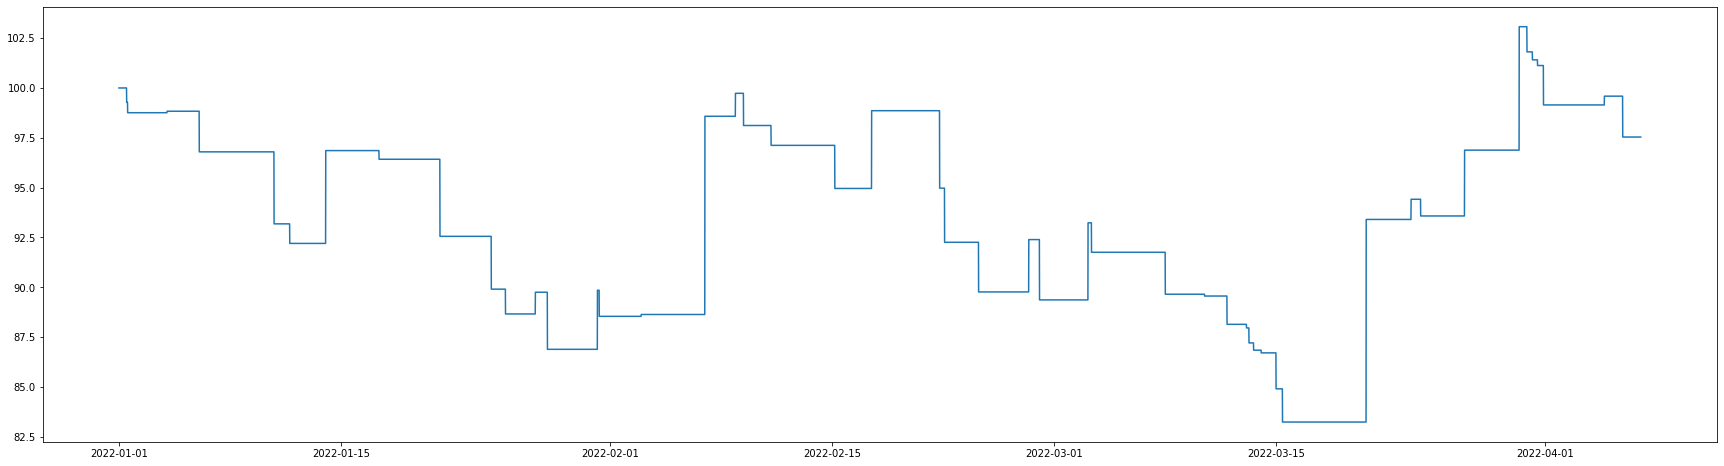

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 4.34%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 30.61%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 30.61%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count       49.000000
mean         0.003376
std          3.391236
min         -4.008182
25%         -2.056843
50%         -0.853602
75%          0.443956
max         12.199675


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count       49.000000
mean         0.003376
std          3.391236
min         -4.008182
25%         -2.056843
50%         -0.853602
75%          0.443956
max         12.199675




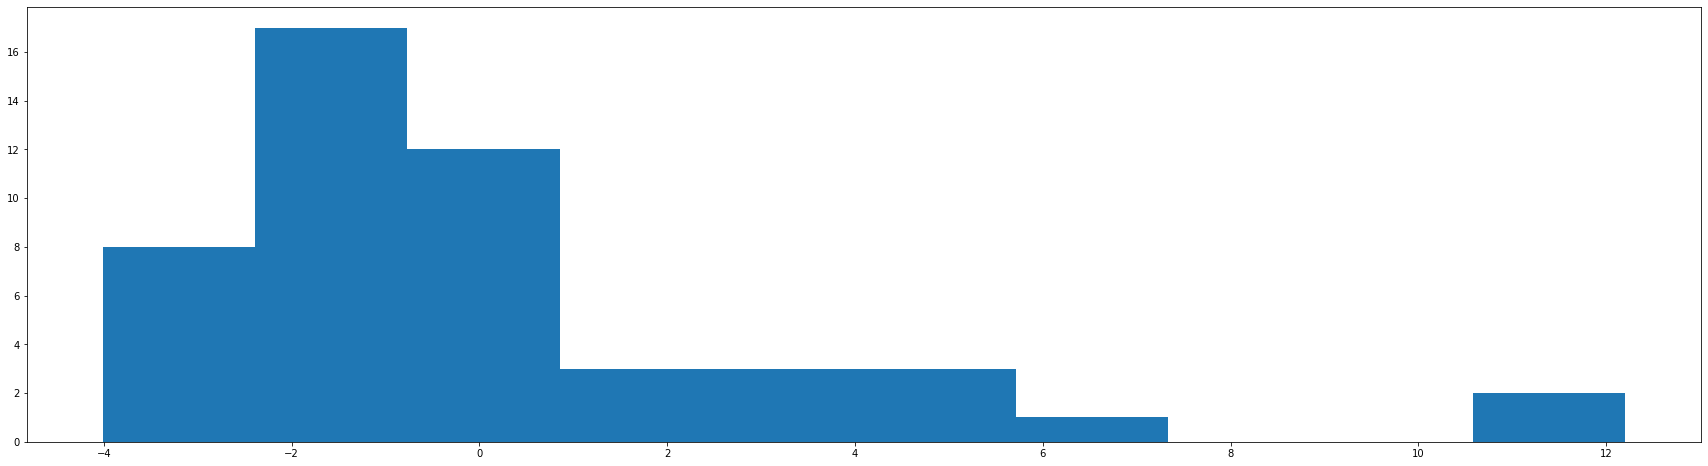

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)